In [1]:
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Draw
import itertools
import numpy as np

In [3]:
def disp100mol(mol):
    im_mol=Draw.MolToImage(mol,size=(200,200))
    display(im_mol.resize((150,150),resample=5))
    
def Base_n_to_10(l_X,n):
    out = 0
    for i in range(1,len(l_X)+1):
        out += int(l_X[-i])*(n**(i-1))
    return out#int out

In [22]:
l_p_atm=['C','H','H','H']
l_vlc=[4,1,1,1]
n_atm=len(l_c_atm)
#原子のリスト
l_bond_p=[[[0]*n_atm]]
#取りうる隣接行列の行
#最初の行は後から決まるので0で良い
for k in range(1,len(l_c_atm)):
    n_atm_r=k+1
    #注目すればいい原子の数
    #三角形の横方向の数+1
    #詳しくは足してnになる組み合わせの数の応用
    #足してn以下になる組み合わせの数を参照
    n_valence=l_vlc[k]
    l_cr=list(itertools.combinations_with_replacement(list(range(n_atm_r)),n_valence))
    l_bond_r_p=[]
    #隣接行列のある1行が取りうる行のリスト
    for i in range(len(l_cr)):
        l_bond=[0]*n_atm
        for j in range(n_atm_r-1):
            l_bond[j]=l_cr[i].count(j)
        l_bond_r_p.append(l_bond)
    l_bond_p.append(l_bond_r_p)
l_bond_p

[[[0, 0, 0, 0]],
 [[1, 0, 0, 0], [0, 0, 0, 0]],
 [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 0]],
 [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]]]

In [23]:
ar_bond_p=np.array(list(itertools.product(*l_bond_p)))
for i in range(ar_bond_p.shape[0]):
    for j in range(ar_bond_p.shape[1]):
        ar_bond_p[i,:j,j]=ar_bond_p[i,j,:j]
        #対称行列にする
ar_b_cons=ar_bond_p.sum(axis=1)<=np.array([[4,1,1,1]])
#結合数が原子価以下のものをbooleanとして抽出
ar_b_ind=np.all(ar_b_cons,axis=1)
#すべての原子が、結合数が原子価以下であったらその隣接行列は整合性があると判断する
#その整合性のあるもののindex
ar_bond_cons=ar_bond_p[ar_b_ind]
#整合性のあるもののみ取り出す。
ar_bond_cons[:3]

array([[[0, 1, 1, 1],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]],

       [[0, 1, 1, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 1],
        [1, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 0, 0, 0]]])

In [24]:
for i in range(ar_bond_cons.shape[0]):
    for j in range(ar_bond_cons.shape[1]):
        ar_bond_cons[i,j,j:]=0
        #下三角行列にする。
        
l_l_base=[]
for i in range(ar_bond_cons.shape[0]):
    l_base=[]
    for j in range(ar_bond_cons.shape[1]):
        l_base.append(Base_n_to_10(ar_bond_cons[i,j,:],l_vlc[j]+1))
        #隣接行列を原子価+1進数とみなして十進数に直す。
        #この十進数にした数字で並び替えて、
        #同型のグラフを見つけ出す
    l_l_base.append(l_base)
    #十進数に直した数字のリストをリストに追加
ar_base=np.array(l_l_base)
print(ar_base[:3])
#このar_baseの1行について、原子種ごとにソートしたものは
#同じグラフについては同じになる。(ただし同じにならない場合もある。)
#ある一つのグラフに対して1意に決まるカノニカルラベルと言える
#(厳密には違うが)

[[0 8 8 8]
 [0 8 8 0]
 [0 8 0 8]]


In [25]:
ar_c_atm=np.array(l_c_atm)
#原子種のリストをarray化
ar_uni=np.unique(ar_c_atm)
#原子のリストのユニークな要素を取り出し
l_c_table=[]
l_cons_b=[]
for i in range(len(ar_base)):
    l_sorted=[]
    for atm in ar_uni:
        ar_uni_b=(ar_c_atm==atm)
        #原子リストのうち、注目している原子種と一致するところをbooleanで取り出す
        l_sorted.extend(np.sort(ar_base[i][ar_uni_b]))
        #そのbooleanで取り出してsortし、原子種ごとにカノニカルラベルを作成
        #それをリストに追加し、グラフ全体のカノニカルラベルとする。
    if l_sorted not in l_c_table:
        #そのグラフ全体のカノニカルラベルがチェック表になければ、追加
        l_c_table.append(l_sorted)
        #カノニカルラベルがユニークなもののindexを追加
        l_cons_b.append(i)
ar_bond_can=ar_bond_cons[l_cons_b]
print('カノニカルラベルで絞った組み合わせ:'+str(len(ar_bond_can)))

カノニカルラベルで絞った組み合わせ:8


In [26]:
class Compound:
    def __init__(self,l_atmind,l_o_atm,m_o_b):
        self.l_atm=l_atmind.copy()
        #l_atmindを新しく化合物とする
        self.l_o_atm=l_o_atm.copy()
        #もとの原子リストをコピー
        self.m_o_b=m_o_b
        #もとの隣接行列をコピー
        self.d_atm={}
        for i in l_atmind:
            self.d_atm[i]=l_o_atm[i]
        #化合物内の原子辞書をつくる

    def addatm(self,i):
        self.l_atm.append(i)
        self.d_atm[i]=self.l_o_atm[i]
        #iを新しく化合物に追加

    def exatms(self,l_t_atm):
        self.l_atm.extend(l_t_atm)
        for i in l_t_atm:
            self.d_atm[i]=self.l_o_atm[i]
        #l_t_atmを新しく化合物に追加

    def calcAd(self):
        #化合物に属する原子を全部まとめ終わってから
        #隣接行列、隣接リストを算出
        l_adm=[]
        self.l_n_atm=[]
        for i in self.l_atm:
            l_adm.append(self.m_o_b[i,self.l_atm])
            self.l_n_atm.append(self.d_atm[i])
            #原子のリストも作る。
            
        self.m_adm=np.array(l_adm)
        
        self.l_adl=[]
        self.l_s_adl=[]
        self.n_rad=0
        self.l_rad=[]
        self.l_vlc=[0]*self.m_adm.shape[0]
        for i in range(self.m_adm.shape[0]):
            for j in range(i+1,self.m_adm.shape[1]):
                if(self.m_adm[i,j]==0):
                    continue
                self.l_adl.append([i,j,self.m_adm[i,j]])
                self.l_s_adl.append([str(i+1),str(j+1),str(self.m_adm[i,j])])
            if(self.m_adm[i,i]>0):
                self.n_rad+=1
                self.l_rad.append('   '+str(i+1)+'   2')
                self.l_vlc[i]=self.m_adm[i,:i].sum()+self.m_adm[i,i+1:].sum()
    
    def strMolB(self):
        n_atm=len(self.l_atm)
        n_bnd=len(self.l_adl)
        s_mb='\n'+' '*5+'Original'+' '*7+'2D'+'\n'
        s_mb=s_mb+'\n'+' '*2+str(n_atm)+' '*2+str(n_bnd)+'  0  0  0  0  0  0  0  0999 V2000'
        for i in range(self.m_adm.shape[0]):
            s_mb=s_mb+'\n'+'    0.0   '*3+' '+self.l_n_atm[i]+'   0'+'  0'*4+'  '+str(self.l_vlc[i])+'  0'*6
        for bond in self.l_s_adl:
            s_mb=s_mb+'\n'+' '*2+bond[0]+' '*2+bond[1]+' '*2+bond[2]+'  0'
        if(self.n_rad>0):
            s_mb=s_mb+'\nM  RAD  '+str(self.n_rad)
            for rad in self.l_rad:
                s_mb=s_mb+rad
        s_mb=s_mb+'\n'+'M  END'
        return s_mb
    
    def GenMol(self):
        #Molオブジェクトを作る
        self.calcAd()
        #隣接リストを作成し、
        self.cmol=Chem.MolFromMolBlock(self.strMolB(),removeHs=False)
        #MolBlockを作成し、そのMBからMolオブジェクトを生成
        AllChem.Compute2DCoords(self.cmol)
        #2次元座標を計算
        
        l_atms=list(self.cmol.GetAtoms())
        for i in range (self.m_adm.shape[0]):
            if(self.m_adm[i][i]>0):
                l_atms[i].SetNumRadicalElectrons(int(self.m_adm[i,i]))

In [50]:
class Products:
    #生成物全体のクラス
    def __init__(self,l_p_atm,m_bnd,l_vlc):
        self.l_p_atm=l_p_atm
        self.m_bnd=m_bnd
        self.l_vlc=l_vlc
    def SmtrBnd(self):
        #対称行列にして、ラジカルも計算
        for i in range(self.m_bnd.shape[0]):
            self.m_bnd[:i,i]=self.m_bnd[i,:i]
            #対称行列にする
            self.m_bnd[i,i]=self.l_vlc[i]-self.m_bnd[:i,i].sum()-self.m_bnd[i+1:,i].sum()
            #i,i要素はラジカルなので原子価から結合数を引く
    def SplitComp(self):
        comp_c=0
        self.ar_c_t=(np.ones([len(self.l_p_atm)])*-1).astype('int')
        #どの原子がどの原子群に属しているかというリスト
        self.l_comp=[]
        for i in range(self.m_bnd.shape[0]):
            for j in range(i):
                #下三角行列のみ走査
                if(self.m_bnd[i,j]==0):
                    continue
                ar_b_c=self.ar_c_t[[i,j]]==[-1,-1]
                #原子が原子群に属しているかいないかのチェック
                if(np.all(ar_b_c)):
                    #i,jがどちらとも属していない場合
                    self.ar_c_t[[i,j]]=comp_c
                    self.l_comp.append(Compound([i,j],self.l_p_atm,self.m_bnd))
                    comp_c+=1
                elif(ar_b_c[0]):
                    #iだけが所属していない場合
                    self.ar_c_t[i]=self.ar_c_t[j]
                    self.l_comp[self.ar_c_t[j]].addatm(i)
                elif(ar_b_c[1]):
                    #jだけが所属していない場合
                    self.ar_c_t[j]=self.ar_c_t[i]
                    self.l_comp[self.ar_c_t[i]].addatm(j)
                else:
                    if(self.ar_c_t[i]<self.ar_c_t[j]):
                        Comp=l_comp.pop(self.ar_c_t[j])
                        #繋がっていると分かった原子群同士のうち番号が大きい方をpopする
                        l_comp[self.ar_c_t[i]].exatms(Comp.l_atm)
                        #番号が小さい方に追加
                        for atm_num in Comp.l_atm:
                            self.ar_c_t[atm_num]=self.ar_c_t[i]
                            #繋がっていると分かった原子群のそれぞれの原子の属する原子群の番号を小さい方に統一
                    elif(self.ar_c_t[j]<self.ar_c_t[i]):
                        Comp=l_comp.pop(self.ar_c_t[i])
                        l_comp[self.ar_c_t[j]].exatms(Comp.l_atm)
                        for atm_num in Comp.l_atm:
                            self.ar_c_t[atm_num]=self.ar_c_t[j]
        for i in range(self.m_bnd.shape[0]):
            if(self.ar_c_t[i]==-1):
                #原子群に分けた時点でどこにも所属していないものは原子
                self.ar_c_t[i]=comp_c
                self.l_comp.append(Compound([i],self.l_p_atm,self.m_bnd))
                comp_c+=1
    def GenMols(self):
        #Molオブジェクトを生成
        self.SmtrBnd()
        self.SplitComp()
        for Comp in self.l_comp:
            Comp.GenMol()
    def Dispmols(self):
        self.GenMols()
        for Comp in self.l_comp:
            disp100mol(Comp.cmol)
            print(Chem.MolToSmiles(Comp.cmol))

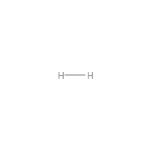

[H][H]


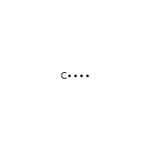

[C]


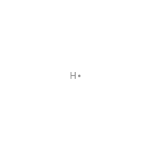

[H]


In [55]:
p_t=Products(l_p_atm,ar_bond_can[5],l_vlc)
p_t.Dispmols()

組み合わせ:0


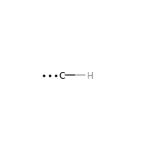

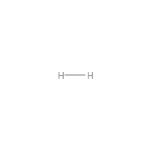


組み合わせ:1


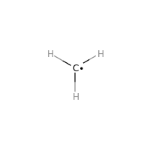

In [18]:
l_p_atm=['C','H','H','H','H']

l_mb=[]
l_b=[[0,0,1],[0,1,0],[1,0,0]]
n_hs=len(l_b)
l_hb=list(itertools.combinations_with_replacement(l_b, n_hs))
for j in range(len(l_hb)):
    l_hb_p=[]
    for i in range(n_hs):
        l_1hb=l_hb[j][i].copy()
        l_1hb.insert(i+1,0)
        l_hb_p.append(l_1hb)
    m_bh=np.array(l_hb_p)
    v_b_c=np.insert(m_bh[:,0],0,0)
    #炭素のarrayを作る
    m_b=np.concatenate([v_b_c[np.newaxis,:],m_bh],axis=0)
    #炭素のarrayと水素のarrayを結合
    if(np.all(m_b==m_b.T)):
        m_b[0,0]=4-m_b[0,:].sum()
        l_mb.append(m_b)

l_p_comp=[]
n_p_comb=0
for m_p_b in l_mb:
    for i in range(m_p_b.shape[0]):
        for j in range(m_p_b.shape[1]):
            if i>j:
                m_p_b[i,j]=m_p_b[j,i]

    d_atom = {}
    #どの原子がどの原子群に属しているかという辞書
    d_comp={}
    #原子群ごとにどの原子が属しているかという辞書
    d_lt={}
    comp_c=0
    for i in range(m_p_b.shape[0]):
        for j in range(i+1,m_p_b.shape[1]):
            if(m_p_b[i,j]==0):
                continue
            if i not in d_atom.keys():
                if j not in d_atom.keys():
                    d_atom[i]=comp_c
                    d_atom[j]=comp_c
                    d_comp[comp_c]=Compound([i,j],l_p_atm,m_p_b)
                    comp_c+=1
                    #i,ｊを新しく原子群に追加
                else:
                    d_atom[i]=d_atom[j]
                    d_comp[d_atom[j]].addatm(i)
                    #iをｊの属している原子群に
            else:
                if j not in d_atom.keys():
                    d_atom[j]=d_atom[i]
                    d_comp[d_atom[i]].addatm(j)
                    #iをｊの属している原子群に
                else:
                    if(d_atom[i]<d_atom[j]):
                        Comp=d_comp.pop(d_atom[j])
                        #つながっているとわかった原子群をpopで取り出す
                        d_comp[d_atom[i]].exatms(Comp.l_atm)
                        #番号の若い方に追加
                        for atm_num in Comp.l_atm:
                            d_atom[atm_num]=d_atom[i]
                            #つながっているわかった原子群の属する原子群を若い方に更新
                    elif(d_atom[i]>d_atom[j]):
                        Comp=d_comp.pop(d_atom[i])
                        #つながっているとわかった原子群をpopで取り出す
                        d_comp[d_atom[j]].exatms(Comp.l_atm)
                        #番号の若い方に追加
                        for atm_num in Comp.l_atm:
                            d_atom[atm_num]=d_atom[j]
    print('組み合わせ:'+str(n_p_comb))
    for k in d_comp:
        c=d_comp[k]
        c.GenMol()
        disp100mol(c.cmol)
    print()
    
    l_p_comp.append(d_comp.copy())
    n_p_comb+=1